In [1]:
%matplotlib inline

In [2]:
%load_ext line_profiler

user-defined LaTeX commands
$\newcommand{\Er}{\mathcal{E}}$
$\newcommand{\Xset}{\mathcal{X}}$
$\newcommand{\Yset}{\mathcal{Y}}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\l}{\mathcal{l}}$
$\newcommand{\pr}{\mathbb{P}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\D}{\mathbb{D}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\I}{\mathbf{I}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\S}{\mathbf{S}}$
$\newcommand{\e}{\mathbf{e}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\v}{\mathbf{v}}$
$\newcommand{\phivec}{\boldsymbol{\phi}}$
$\newcommand{\sign}{\mathrm{sign}}$
$\newcommand{\F}{\mathcal{F}}$

$\newcommand{\tg}{\mathrm{tg}}$
$\newcommand{\ctg}{\mathrm{ctg}}$
$\newcommand{\arctg}{\mathrm{arctg}}$
$\newcommand{\cov}{\mathrm{cov}}$
$\newcommand{\argmax}{\mathrm{argmax}}$
$\newcommand{\argmin}{\mathrm{argmin}}$

$\newcommand{\condit}{\thinspace\rvert\thinspace}$

$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\b}{\mathbf{b}}$
$\newcommand{\a}{\mathbf{a}}$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from ggplot import *

In [5]:
from matplotlib import colors as clrs
from matplotlib.colors import ListedColormap

In [6]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.stats import rv_discrete

In [8]:
from timeit import default_timer as timer

In [9]:
from sympy.utilities.iterables import multiset_permutations

In [10]:
from copy import copy

In [11]:
import sys

# Print iterations progress
def printProgress(iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    """\n    Call in a loop to create terminal progress bar\n    @params:\n        iteration   - Required  : current iteration (Int)\n        total       - Required  : total iterations (Int)\n        prefix      - Optional  : prefix string (Str)\n        suffix      - Optional  : suffix string (Str)\n        decimals    - Optional  : positive number of decimals in percent complete (Int)\n        barLength   - Optional  : character length of bar (Int)\n    """
    formatStr       = "{0:." + str(decimals) + "f}"
    percents        = formatStr.format(100 * (iteration / float(total)))
    filledLength    = int(round(barLength * iteration / float(total)))
    bar             = '█' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [12]:
def step_function(x, margin=0, label=[0, 1]):
    return np.where(x >= margin, label[1], label[0])

### Markov model

Markov model is defined by:
* Initial probability distribution for states $\pi$
* Transition probabilities $A(\x,\x^{\prime})=\{\a_{ij}\}$, where $\a_{ij}=\pr(\x^{\prime}=S_i\condit \x = S_j)$

**Markov property:**
* Dependence only on the last event (not all the history):
$$\displaystyle{\pr(\x_t=S_{j_t}\condit \x_{t-1}=S_{j_{t-1}},\dots,\x_1=S_{j_1})=\pr(\x_t=S_{j_t}\condit \x_{t-1}=S_{j_{t-1}})}$$

### Hidden Markov Model

**Hidden markov Model specification**
* $\x_t$ - hidden state
* $\y_{1:t}=(y_1,\ldots,y_t)$ - observations in moments $1,\ldots,t$
* $\pi(\x_1)$ - initial state probabilities array
* $\b_k(y_t) = \pr(y_t=O\condit \x_t=k)$ - emission probability
* $\a_{ij}=\pr(\x_t=S_j\condit \x_{t-1}=S_i)$ - transition probability
* $\pr(\x_t,\y_{1:t})$ - joint probability

**Model definition:** 
* Model $\displaystyle{\mathcal{M}\left(\pi, A, B \right)}$
* Alphabet of states: $S_1,\ldots,S_N$
* Alphabet of observations: $O_1,\ldots,O_M$
* Initial state probabilities: $\pi=(\pi_1,\ldots,\pi_N)$
* Transition matrix: $A=\left(a_{ij}\right)_{i,j=1}^N\in\R^{N\times N}$
* Emission matrix: $B=\left(b_i(O_j)\right)_{i=1,j=1}^{N, M}\in\R^{N\times M}$

**Model assumptions**
* **Markov property:** $\displaystyle{\pr(\x_t\condit \x_{1:t-1})=\pr(\x_t\condit \x_{t-1})}$
* **Independence assumption:** $\displaystyle{\pr(\y_t\condit \y_{1:t-1},\x_{1:t})=\pr(\y_t\condit \x_t)}$

**Three problems of HMM**
* Find the probability of observed data conditioned on the model $\mathcal{M}$
* Given the data (observations) and the model $\mathcal{M}$, find the most probable sequence od states
* Given the data (observations) estimate the model $\mathcal{M}$ parameters

**The First Problem: find the probability of observed data conditioned on the model $\mathcal{M}$**

**Special probabilities** for the first problem

* **Forward probabilities:** $\displaystyle{\alpha_t(\x_t=i)=\alpha_t(i)=\pr(\x_t=i, \y_{1:t})}$ - the probability of arriving to state $i$ at the time $t$ emitting the observations up to time $t$.
* **Backward probabilities:** $\displaystyle{\beta_t(\x_t=i)=\pr(\y_{t+1:T} \condit \x_t=i)}$ - the probability of emitting the remaining sequence from $t+1$ until $T$ after being at the hidden state $\x_t=i$ at time $t$.

**Probability chain rule:**
$$\displaystyle{\pr\left(A_n,\ldots,A_1\right)=\pr\left(A_n\condit A_{n-1},\ldots,A_1\right)\cdot\pr\left(A_{n-1},\ldots,A_1\right)}$$

**FORWARD ALGORITHM**

Goal: solve decoding problem. Algorithm computes the joint probability $\pr(\x_t,\y_{1:t})$
* Start with definition $$\displaystyle{\alpha_t(\x_t)=\pr(\x_t,\y_{1:t})=\sum_{\x_{t-1}}\pr(\x_t,\x_{t-1},\y_{1:t-1})}$$
* Apply chain rule to the summands: $$\displaystyle{\alpha_t(\x_t)=\sum_{\x_{t-1}}\pr(\y_t\condit \x_t, \x_{t-1}, \y_{1:1-t-1})\pr(\x_t\condit \x_{t-1},\y_{1:t-1})\pr(\x_{t-1},\y_{1:t-1})}$$
* Due to conditional independence the last expression simplifies to: $$\displaystyle{\alpha_t(\x_t)=\underbrace
{\pr(\y_t\condit \x_t)}_{\b_{\x_t}(\y_t)}\sum_{\x_{t-1}}\underbrace{\pr(\x_t\condit \x_{t-1})}_{\a(\x_{t-1},\x_t)}\alpha_{t-1}(\x_{t-1})}$$
* **ALGORITHM**:
    * **Initialization:** $\displaystyle{\alpha_1(i)=\pi_i\b_i(\y_1)}$, $1\leq i \leq N$
    * **Induction:** for $t=2,\ldots,T$
    $$\displaystyle{\alpha_t(j)=\b_j(\y_t)\sum_{i=1}^N\alpha_{t-1}(i)\a_{ij}}, \quad 1\leq j \leq N$$
    * **Termination:** return $\pr(\y_{1:t})=\sum_{i=1}^N\alpha_T(i)$

**Implementation of Forward algorithm**
```python
def _forward(self, y):
        # number of observations
        T = len(y)
        # trellis for forward probabilities
        alpha = np.zeros(self.N*T).reshape(self.N, T)
        # scaling term
        self.c = np.zeros(T)
        # initialization
        pi = self._init_state_dist().pk
        e = [self._emission_dist(i).pmf(int(y[0])) for i in np.arange(self.N)]
        self.e = e
        alpha[:,0] = pi*e
        self.c[0] = 1./np.sum(alpha[:, 0])
        alpha[:, 0] = alpha[:, 0]*self.c[0]
        for t in range(1, T):
            for j in range(self.N):
                a = np.array([self._transition_dist(i).pmf(j) for i in np.arange(self.N)]).T
                alpha[j,t] = np.dot(alpha[:, t-1], a)*self._emission_dist(j).pmf(int(y[t]))
            self.c[t] = 1./np.sum(alpha[:, t])
            alpha[:, t] = alpha[:, t]*self.c[t]
        self.alpha = alpha
        alpha = np.divide(alpha, np.cumprod(self.c))
        return np.sum(alpha[:, T-1])
```

**Scaling problem**

The *scaling term* in the code above addresses the underflow problem while performing computation over small values. Multiplying a big amount of probabilities can cause the problem, that estimated values go to zero very fast.

The common approach is:
* **Initialization:**
    * $\alpha^{\prime}_1(i)=\alpha_1(i)$;
    * $c_1=\left(\sum_{i=1}^N\alpha^{\prime}_1(i)\right)^{-1}$
    * $\hat{\alpha}_1(i)=c_1\alpha^{\prime}_1(i)$
* **Induction:**
    * $\displaystyle{\alpha^{\prime}_t(j)=\b_j(\y_t)\sum_{i=1}^N\hat{\alpha}_{t-1}(i)\a_{ij}}$, $1\leq j \leq N$
    * $c_t=\left(\sum_{i=1}^N\alpha^{\prime}_t(i)\right)^{-1}$
    * $\hat{\alpha}_t(i)=c_t\alpha^{\prime}_t(i)$
* **Termination:**
    * $\displaystyle{\hat{\alpha}_t(i)=\alpha_t(i)\prod_{\tau=1}^tc_{\tau}=\alpha_t(i)\mathbf{C}_t}$

**BACKWARD ALGORITHM**

* Start with the definition $$\displaystyle{\beta_t(\x_t=i)=\pr(\y_{t+1:T}\condit \x_t=i)=\sum_{j}\pr(\x_{t+1}=j,\y_{t+1:T}\condit \x_t=i)}$$
* Apply chain rule: $$\displaystyle{\pr(\x_{t+1}=j,\y_{t+1:T}\condit \x_t=i)=\pr(\y_{t+2:T},\y_{t+1},\x_{t+1}=j\condit \x_t=i)=\\=\pr(\y_{t+2:T}\condit \y_{t+1},\x_{t+1}=j, \x_t=i)\pr(\y_{t+1} \condit \x_{t+1}=j,\x_t=i)\pr(\x_{t+1}=j\condit \x_t=i)}$$
* Due to conditional independence the above expression simplifies to: $$\displaystyle{\pr(\y_{t+2:T}\condit \x_{t+1}=j)\pr(\y_{t+1}\condit \x_{t+1}=j)\pr(\x_{t+1}=j\condit \x_t=i)}$$
* From the definition of backward probabilities follows, that: $$\displaystyle{\pr(\y_{t+2:T}\condit \x_{t+1}=j)=\beta_{t+1}(\x_{t+1}=j)}$$
* we obtain recursion for backward probabilities: $$\displaystyle{\beta_t(\x_t=i)=\sum_{j}\beta_{t+1}(\x_{t+1}=j)\pr(\y_{t+1}\condit \x_{t+1}=j)\pr(\x_{t+1}=j\condit \x_t=i)}$$
* recursion in terms of transition and emission probabilities: $$\displaystyle{\beta_t(\x_t=i)=\sum_{j}\beta_{t+1}(\x_{t+1}=j)\b_j(\y_{t+1})\a_{ij}}$$
* **ALGORITHM**
    * **Initialization:** $\displaystyle{\beta_T(i)=1}$, $1\leq i \leq N$
    * **Induction:** for $t=T-1,\ldots,1$
        * $\displaystyle{\beta_t(i)=\sum_{j=1}^N\a_{ij}\b_j(\y_{t+1})\beta_{t+1}(j)}$
    * **Termination:** $\displaystyle{\pr(\y_{1:T})=\sum_{i=1}^N\pi_i\b_i(\y_1)\beta_1(i)}$

**Implementation of backward algorithm**
```python
def _backward(self, y):
        # number of observations
        T = len(y)
        # trellis for forward probabilities
        beta = np.zeros(self.N*T).reshape(self.N, T)
        # initialization
        beta[:, T-1] = np.ones(self.N)
        beta[:, T-1] = beta[:, T-1]*self.c[T-1]
        for t in range(T-2, -1, -1):
            for i in range(self.N):
                a = np.array([self._transition_dist(i).pmf(j)*self._emission_dist(j).pmf(int(y[t+1])) for j in np.arange(self.N)]).T
                beta[i, t] = np.dot(beta[:, t+1], a)
            beta[:,t] = beta[:,t]*self.c[t]
        self.beta = beta
        
        beta = np.divide(beta, np.cumprod(self.c[::-1])[::-1])
        pi = self._init_state_dist().pk
        b = np.array([self._emission_dist(i).pmf(int(y[0])) for i in np.arange(self.N)])
        return np.sum(pi*b*beta[:, 0])
```

**Scaling problem**

* **Initialization:** 
    * $\beta^{\prime}_T(i)=1$
    * $\hat{\beta}_T(i)=c_T\beta^{\prime}_T(i)$
* **Induction:**
    * $\displaystyle{\beta^{\prime}_t(i)=\sum_{j=1}^N\a_{ij}\b_j(\y_{t+1})\hat{\beta}_{t+1}(j)}$
    * $\hat{\beta}_t(i)=c_t\beta^{\prime}_t(i)$
* **Termination:**
    * $\displaystyle{\hat{\beta}_t(i)=\beta_t(i)\prod_{\tau=t}^Tc_{\tau}=\beta_t(i)\mathbf{D}_t}$
    
**Note, that**
* $\displaystyle{\mathbf{C}_t\cdot\mathbf{D}_{t+1}=\mathbf{C}_T}$

**The Second Problem: given the data (observations) and the model $\mathcal{M}$, find the most probable sequence od states**

**Special probabilities** for the second problem
* Auxiliary variables: 
    * maximum probability to reach $S_i$ on the step $t$ over all paths with given observations: $$\displaystyle{\delta_t(i)=\underset{\x_1,\ldots,\x_{t-1}}{\max}\pr\left(\x_t=i,\y_{1:t}\condit \mathcal{M}\right)}$$
    * array of arguments of $\delta_t(i)$: $\psi_t(i)$

**Viterbi algorithm**

* **Initialization:** $\delta_1(i)=\pi_i\b_i(\y_1)$, $\psi_1(i)=0$, $1\leq i \leq N$
* **Induction:** for $t=2,\ldots,T$
    * $\displaystyle{\delta_t(j)=\underset{i}{\max}\left(\delta_{t-1}(i)\a_{ij}\right)\b_j(\y_t)}$
    * $\displaystyle{\psi_t(j)=\underset{i}{\argmax}\left(\delta_{t-1}(i)\a_{ij}\right)}$, $1\leq j \leq N$
* **Termination:**
    * $\displaystyle{\Delta^*=\underset{i}{\max}\delta_T(i)}$
    * $\displaystyle{\x^*_t=\underset{i}{\argmax}\delta_T(i)}$
* **Traceback:** for $t=T-1,\ldots,1$
    * $\x^*_t=\psi(\x^*_{t+1})$
    * $\x^*_{1:T}=\left(\x_1^*,\ldots,\x_T^*\right)$

**Scaling problem**

**Viterbi algorithm in log scale**

* **Initialization:** $\delta_1(i)=-\log \pi_i-\log\b_i(\y_1)$, $\psi_1(i)=0$, $1\leq i \leq N$
* **Induction:** for $t=2,\ldots,T$
    * $\displaystyle{\delta_t(j)=\underset{i}{\min}\left(\delta_{t-1}(i)-\log\a_{ij}\right)-\log\b_j(\y_t)}$
    * $\displaystyle{\psi_t(j)=\underset{i}{\argmin}\left(\delta_{t-1}(i)-\log\a_{ij}\right)}$, $1\leq j \leq N$
* **Termination:**
    * $\displaystyle{\Delta^*=\underset{i}{\min}\delta_T(i)}$
    * $\displaystyle{\x^*_t=\underset{i}{\argmin}\delta_T(i)}$
* **Traceback:** for $t=T-1,\ldots,1$
    * $\x^*_t=\psi(\x^*_{t+1})$
    * $\x^*_{1:T}=\left(\x_1^*,\ldots,\x_T^*\right)$

**The Third Problem: given the data (observations) estimate the model $\mathcal{M}$ parameters**

**Auxiliary variables**
* $\displaystyle{\gamma_t(i)=\pr(\x_t=i\condit \y_{1:T}, \mathcal{M})}$ the conditional probability to visit state $S_i$ on the $t$-th step given observations $\y_{1:T}$ and model $\mathcal{M}$
    * In terms of $\alpha_t(i)$ and $\beta_t(i)$ we can get the next expression (from the Bayes rule): $\displaystyle{\gamma_t(i)=\frac{\pr(\x_t=i, \y_{1:T}\condit \mathcal{M})}{\pr\left(\y_{1:T\condit \mathcal{M}}\right)}=\frac{\alpha_t(i)\beta_t(i)}{\pr\left(\y_{1:T\condit \mathcal{M}}\right)}=\frac{\alpha_t(i)\beta_t(i)}{\sum_{j=1}^N\alpha_t(j)\beta_t(j)}}$
* The probability to be in the state $S_i$ at time $t$ and in the state $S_j$ at time $t+1$ given observations: $$\displaystyle{\xi_t(i,j)=\pr\left(\x_{t-1}=i,\x_t=j\condit \y_{1:T}\right)}$$
    * From the Bayes law: $$\displaystyle{\xi_t(i,j)=\frac{\pr\left(\x_{t-1}=i,\x_t=j, \y_{1:T}\condit\mathcal{M}\right)}{\pr\left(\y_{1:T}\condit \mathcal{M}\right)}=\frac{\pr\left(\x_{t-1}=i,\y_{1:t-1}\condit \mathcal{M}\right)\pr\left(\x_t=j,\y_{t:T}\condit \x_{t-1}=i,\mathcal{M}\right)}{\pr\left(\y_{1:T}\condit \mathcal{M}\right)}=\frac{\alpha_{t-1}(i)\pr\left(\x_t=j,\y_t\condit \x_{t-1},\mathcal{M}\right)\pr\left(\y_{t+1:T}\condit \x_t=j,\mathcal{M}\right)}{\pr\left(\y_{1:T}\condit \mathcal{M}\right)}=\frac{\alpha_{t-1}(i)\a_{ij}\b_j(\y_t)\beta_t(j)}{\pr\left(\y_{1:T}\condit \mathcal{M}\right)}}$$
* Connection between $\gamma_t(i)$ and $\xi_t(i,j)$: $$\displaystyle{\gamma_t(i)=\sum_{j=1}^N\xi_t(i,j)}$$

**Baum-Welch algorithm**

* **Initial-state probabilities** - estimate via expected frequency of state $S_i$ on the step 1:
    * $\displaystyle{\hat{\pi}_i=\gamma_1(i)}$, for $1\leq i \leq N$;
* **State-transition probabilities** - estimate via expected number of transitions from $S_i$ to $S_j$ divided by the expected number of transitions from the state $S_i$:
    * $\displaystyle{\hat{\a}_{ij}=\frac{\sum_{t=2}^T\xi_t(i,j)}{\sum_{t=2}^T\gamma_t(i)}}$, for $1\leq i,j\leq N$;
* **Output probabilities** - estimate via expected number of visits to $S_j$ and observations $O_k$ divided by the expected number of visits to $S_j$:
    * $\displaystyle{\hat{\b}_j(k)=\frac{\sum_{t=1}^T\rvert_{\y_t=k}\gamma_t(j)}{\sum_{t=1}^T\gamma_t(j)}}$, for $1\leq j\leq N$, $1\leq k \leq M$
    
On each step we get $\displaystyle{\pr\left(\y_{1:T}\condit\mathcal{\hat{M}}\right)\geq \pr\left(\y_{1:T}\condit\mathcal{M}\right)}$, but this doesn't guarantee a **global** maximum.

**Scaling problem**

* **State-transition probabilities:**
    * $\displaystyle{\hat{\a}_{ij}=\frac{\sum_{t=2}^T\xi_t(i,j)}{\sum_{t=2}^T\gamma_t(i)}=\frac{\sum_{t=2}^T\hat{\alpha}_{t-1}(i)\a_{ij}\b_j(\y_{t})\hat{\beta}_{t}(j)}{\sum_{t=2}^T\hat{\alpha}_t(i)\hat{\beta}_t(i)/c_t}}$;
* **Output probabilities:** 
    * $\displaystyle{\hat{\b}_j(k)=\frac{\sum_{t=1}^T\rvert_{\y_t=k}\gamma_t(j)}{\sum_{t=1}^T\gamma_t(j)}=\frac{\sum_{t=1}^T\rvert_{\y_t=k}\hat{\alpha}_t(j)\hat{\beta}_t(j)/c_t}{\sum_{t=1}^T\hat{\alpha}_t(j)\hat{\beta}_t(j)/c_t}}$

In [13]:
class HiddenMarkovModel(object):
    """
    Hidden Markov Model class 
    
    Parameters:
    -----------
    
    - S: Number of states
    - O: Emission alphabet capacity
    - A: Transition matrix
    - E: Emission matrix
    - a0: Initial state probabilities 
    """
    def __init__(self, A, E, a0, eps = 0.0001):
        # number of states
        self.N = A.shape[0]
        # observations capacity
        self.M = E.shape[1]
        self.A = A
        self.E = E
        self.a0 = a0
        self.eps = eps
        
    def _init_state_dist(self):
        return rv_discrete(name='init_state_dist', values=(np.arange(self.N), self.a0))
        
    def _transition_dist(self, state):
        return  rv_discrete(name='transition_dist', values=(np.arange(self.N), self.A[state, :]))
    
    def _emission_dist(self, state):
        return  rv_discrete(name='emission_dist', values=(np.arange(self.M), self.E[state, :]))
                
    def sample(self, n):
        # initialize states and observations history
        X = np.zeros(n)
        y = np.zeros(n)
        # initial state
        X[0] = self._init_state_dist().rvs()
        y[0] = self._emission_dist(int(X[0])).rvs()
        for i in range(1, n):
            X[i] = self._transition_dist(int(X[i-1])).rvs()
            y[i] = self._emission_dist(int(X[i])).rvs()
        
        return X, y
    
    def _forward(self, y):
        # number of observations
        T = len(y)
        # trellis for forward probabilities
        alpha = np.zeros(self.N*T).reshape(self.N, T)
        # scaling term
        self.c = np.zeros(T)
        # initialization
        pi = self._init_state_dist().pk
        e = [self._emission_dist(i).pmf(int(y[0])) for i in np.arange(self.N)]
        alpha[:,0] = pi*e
        self.c[0] = 1./np.sum(alpha[:, 0])
        alpha[:, 0] = alpha[:, 0]*self.c[0]
        for t in range(1, T):
            for j in range(self.N):
                a = np.array([self._transition_dist(i).pmf(j) for i in np.arange(self.N)]).T
                alpha[j,t] = np.dot(alpha[:, t-1], a)*self._emission_dist(j).pmf(int(y[t]))
            self.c[t] = 1./np.sum(alpha[:, t])
            alpha[:, t] = alpha[:, t]*self.c[t]
        self.alpha = alpha
        alpha = np.divide(alpha, np.cumprod(self.c))
        return np.sum(alpha[:, T-1])
    
    def _backward(self, y):
        # number of observations
        T = len(y)
        # trellis for forward probabilities
        beta = np.zeros(self.N*T).reshape(self.N, T)
        # initialization
        beta[:, T-1] = np.ones(self.N)
        beta[:, T-1] = beta[:, T-1]*self.c[T-1]
        for t in range(T-2, -1, -1):
            for i in range(self.N):
                a = np.array([self._transition_dist(i).pmf(j)*self._emission_dist(j).pmf(int(y[t+1])) for j in np.arange(self.N)]).T
                beta[i, t] = np.dot(beta[:, t+1], a)
            beta[:,t] = beta[:,t]*self.c[t]
        self.beta = beta
        
        beta = np.divide(beta, np.cumprod(self.c[::-1])[::-1])
        pi = self._init_state_dist().pk
        b = np.array([self._emission_dist(i).pmf(int(y[0])) for i in np.arange(self.N)])
        return np.sum(pi*b*beta[:, 0])
    
    def viterbi(self, y):
        # number of observations
        T = len(y)
        x = np.zeros(T)
        # trellis for Viterbi algorithm
        delta = np.zeros(self.N*T).reshape(self.N, T)
        psi = np.zeros(self.N*T).reshape(self.N, T)
        # initialization
        pi = np.log(self._init_state_dist().pk)
        b = np.log(np.array([self._emission_dist(i).pmf(int(y[0])) for i in np.arange(self.N)]))
        delta[:,0] = - pi - b
        for t in range(1, T):
            for j in range(self.N):
                a = np.log(np.array([self._transition_dist(i).pmf(j) for i in np.arange(self.N)])).T
                delta[j, t] = np.min(delta[:, t-1] - a) - np.log(self._emission_dist(j).pmf(int(y[t])))
                psi[j, t] = np.argmin(delta[:, t-1] - a)
        # finally
        D = np.min(delta[:, T-1])
        x[T-1] = np.argmin(delta[:, T-1])
        # trace back
        for t in range(T-2, -1, -1):
            x[t] = psi[int(x[t+1]), t+1]
        return x
    
    def baum_welch(self, y, max_iter=25):
        converged = False
        T = len(y)
        # initialize model
        self.A = np.random.uniform(size=self.N*self.N).reshape(self.N, self.N)
        self.A = (self.A.T/np.sum(self.A, axis=1)).T
        
        self.E = np.random.uniform(size=self.N*self.M).reshape(self.N, self.M)
        self.E = (self.E.T/np.sum(self.E, axis=1)).T
        self.a0 = np.random.uniform(size=self.N)
        self.a0 = self.a0/np.sum(self.a0)
        self.cost = []
        self.delta = []
        # initialization
        emission_nominator = np.zeros((self.N, self.M))
        xi = np.zeros((self.N, self.N))
        
        progress = 0
        printProgress(progress, max_iter, prefix = 'Progress:', suffix = 'Complete', barLength = 50)
        for step in range(max_iter):
            evidence, _ = self._forward(y), self._backward(y)
            gamma = np.multiply(self.alpha, self.beta)
            gamma = np.divide(gamma, self.c)
            self.gamma = gamma
            for j in range(self.N):
                for k in range(self.M):
                    emission_nominator[j, k] = np.sum([gamma[j, t]*(y[t] == k) for t in range(T)])
            
            
            for i in range(self.N):
                for j in range(self.N):
                    xi[i, j] = np.sum([self.alpha[i, t - 1]\
                                       *self.beta[j, t]\
                                       *self._transition_dist(i).pmf(j)\
                                       *self._emission_dist(j).pmf(int(y[t]))
                                       for t in range(1, T)])                
            
            E = (emission_nominator.T/np.sum(gamma, axis=1)).T
            A = (xi/np.sum(gamma[:,1:], axis=1)).T
            a0 = gamma[:, 0]
            
            self.cost.append(evidence)
            self.delta.append(np.max(np.hstack((np.max(abs(self.a0 - a0)), np.max(abs(A - self.A)), np.max(abs(E - self.E))))))
            
            if np.max(abs(self.a0 - a0)) < self.eps and \
                   np.max(abs(A - self.A)) < self.eps and \
                   np.max(abs(E - self.E)) < self.eps:
                converged = True
            
            self.a0 = a0
            self.A = A
            self.E = E
            
            if converged:
                progress = max_iter
                conv_step = step
                step = max_iter + 1
            else:
                progress+=1
            printProgress(progress, max_iter, prefix = 'Progress:', suffix = 'Complete', barLength = 50)
            if converged:
                print('Converged on step: ', conv_step)
                break
        self.cost = np.array(self.cost)
        self.delta = np.array(self.delta)
        return self.viterbi(y)

**Define some true parameters for the HMM.**

In [14]:
a0 = np.array([0.5, 0.5])

B = np.array([[0.9, 0.1],
              [0.1, 0.1],
              [0.0, 0.8]])

A = np.array([[0.85, 0.15],
              [0.12, 0.88]])

In [15]:
a0 = np.array([0.5, 0.5])

B = np.array([[0.6, 0.1],
              [0.3, 0.1],
              [0.1, 0.8]])

A = np.array([[0.85, 0.15],
              [0.12, 0.88]])

In [16]:
hmm = HiddenMarkovModel(A, B.T, a0, eps=0.0001)

**Sample from HMM**

White and red colored bands define true states.

In [17]:
n = 150

In [18]:
X, y = hmm.sample(n=n)

In [19]:
centers = np.where(X==0)[0]
lb = centers - 0.5
rb = centers + 0.5
spans = np.vstack((lb,rb)).T
c1 = spans.T[0][1:]
c2 = spans.T[1][:-1]
z1 = np.insert(c1[c1!=c2], 0, spans.T[0][0])
z2 = np.append(c2[c1!=c2], spans.T[1][-1])
spans = np.vstack((z1,z2)).T

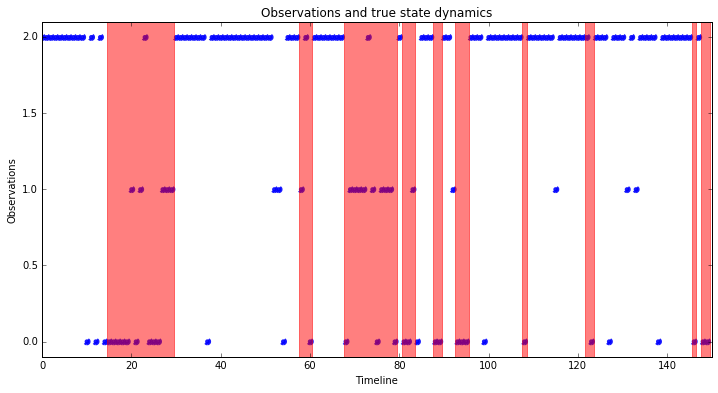

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.scatter(np.arange(n), y, color='blue', lw=3, alpha=0.9, linestyle='dashed')
for span in spans:
    ax.axvspan(span[0], span[1], alpha=0.5, color='red')
plt.ylim(-0.1, 2.1)
plt.ylabel('Observations')
plt.xlabel('Timeline')
plt.title('Observations and true state dynamics')
plt.xlim(0,n);

**Estimate observations probability via forward and backward algorithms.**

In [21]:
print('Probability of observed data (Forward algorithm): ',hmm._forward(y))

Probability of observed data (Forward algorithm):  6.03592740258e-55


In [22]:
print('Probability of observed data (Backward algorithm): ' ,hmm._backward(y))

Probability of observed data (Backward algorithm):  6.03592740258e-55


**Use Viterbi algorithm to estimate the most probable state sequence.**

In [23]:
X_fit = hmm.viterbi(y)

In [24]:
np.mean(X==X_fit)

0.89333333333333331

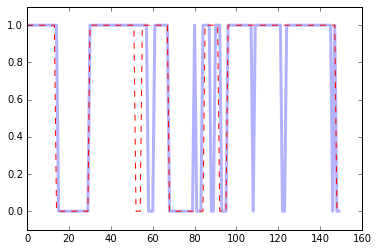

In [25]:
plt.plot(X, color='blue', lw=3, alpha=0.3)
plt.plot(X_fit, color='red', linestyle='dashed')
plt.ylim(-0.1, 1.1);

**Given only the observations, estimate HMM parameters via Baum-Welch algorithm.**

In [26]:
X_fit = hmm.baum_welch(y, max_iter=150)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Converged on step:  23


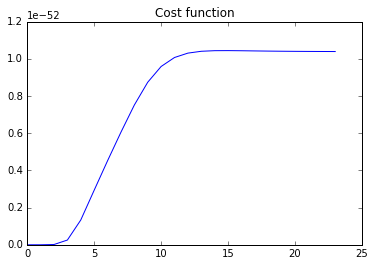

In [27]:
plt.plot(hmm.cost)
plt.title('Cost function');

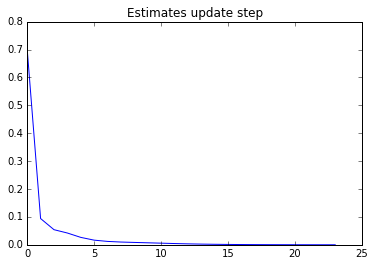

In [28]:
plt.plot(hmm.delta.T)
plt.title('Estimates update step');

In [29]:
centers = np.where(X==0)[0]
lb = centers - 0.5
rb = centers + 0.5
spans = np.vstack((lb,rb)).T
c1 = spans.T[0][1:]
c2 = spans.T[1][:-1]
z1 = np.insert(c1[c1!=c2], 0, spans.T[0][0])
z2 = np.append(c2[c1!=c2], spans.T[1][-1])
spans = np.vstack((z1,z2)).T

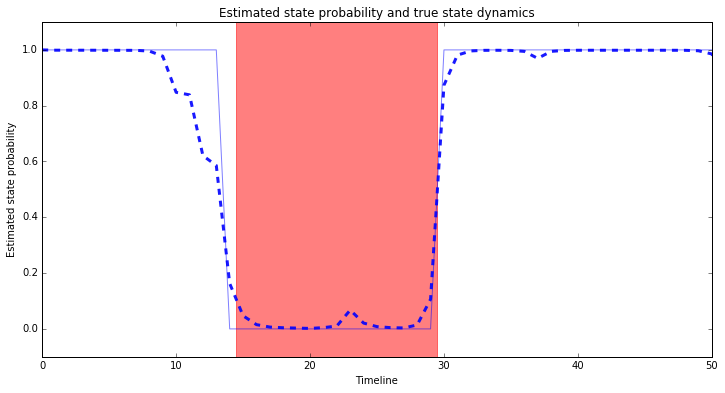

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.plot(hmm.gamma[1], color='blue', lw=3, alpha=0.9, linestyle='dashed')
ax.plot(step_function(hmm.gamma[1], 0.5), color='blue', lw=1, alpha=0.5)
for span in spans:
    ax.axvspan(span[0], span[1], alpha=0.5, color='red')
plt.ylim(-0.1, 1.1)
plt.ylabel('Estimated state probability')
plt.xlabel('Timeline')
plt.title('Estimated state probability and true state dynamics')
plt.xlim(0,50);

In [31]:
print(A, hmm.A)

[[ 0.85  0.15]
 [ 0.12  0.88]] [[ 0.77303182  0.22696818]
 [ 0.11486972  0.88513028]]


In [32]:
%lprun -s -f hmm.viterbi -T lp_results.txt hmm.viterbi(y)
%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 1.32253 s
File: <ipython-input-13-db186554e005>
Function: viterbi at line 89

Line #      Hits         Time  Per Hit   % Time  Line Contents
    89                                               def viterbi(self, y):
    90                                                   # number of observations
    91         1            6      6.0      0.0          T = len(y)
    92         1           14     14.0      0.0          x = np.zeros(T)
    93                                                   # trellis for Viterbi algorithm
    94         1           10     10.0      0.0          delta = np.zeros(self.N*T).reshape(self.N, T)
    95         1            4      4.0      0.0          psi = np.zeros(self.N*T).reshape(self.N, T)
    96                                                   # initialization
    97         1         1783   1783.0      0.1          pi = np.log(self._init_state_dist().pk)
    

### TensorFlow

In [13]:
import tensorflow as tf
from tensorflow.contrib.distributions import Categorical

### TensorFlow Graph vizualization

* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
* http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
* http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [14]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### Hidden Markov Models in TensorFlow

In [708]:
class TFHiddenMarkovModel(object):
    """ Hidden Markov Model class 
    
    Parameters:    
    -----------
        - S: Number of states
        - O: Emission alphabet capacity
        - A: Transition matrix
        - E: Emission matrix 
        - a0: Initial state probabilities 
    """
    def __init__(self, A, B, a0, max_iter=50, epsilon=0.0001):
        # number of states
        self.N = A.shape[0]
        # observations capacity
        self.M = B.shape[1]
        self._A = A
        self._B = B
        self._a0 = a0
        self.max_iter = max_iter
        self.initialized = False
        self.converged = False
        self.epsilon = epsilon

    def _initial_state(self, initialized=False):
        if not initialized:
            self.initialized = True
            return Categorical(p=self.a0.initialized_value(), dtype=tf.int32)
        else:
            return Categorical(p=self.a0, dtype=tf.int32)
    
    def _transition(self, state):
        return Categorical(p=self.A[state, :], dtype=tf.int32)

    def _emission(self, state):
        return Categorical(p=self.B[state, :], dtype=tf.int32)

    def _parameter_reinitialization(self):
        self._A = np.random.uniform(size=self.N*self.N).reshape(self.N, self.N)
        self._A = (self._A.T/np.sum(self._A, axis=1)).T
        
        self._B = np.random.uniform(size=self.N*self.M).reshape(self.N, self.M)
        self._B = (self._B.T/np.sum(self._B, axis=1)).T
        
        self._a0 = np.random.uniform(size=self.N)
        self._a0 = self._a0/np.sum(self._a0)
    
    def _model_definition(self, sampling=True):
        # Transition probability
        self.A = tf.Variable(tf.convert_to_tensor(self._A, dtype=tf.float64), dtype=tf.float64, name='transition_matrix')
        # Emission matrix
        self.B = tf.Variable(tf.convert_to_tensor(self._B, dtype=tf.float64), dtype=tf.float64, name='emission_matrix')
        # Initial state probability
        self.a0 = tf.Variable(tf.convert_to_tensor(self._a0, dtype=tf.float64), dtype=tf.float64, name='init_prob')        
        # observation
        if sampling:
            self.y = tf.Variable([0], dtype=tf.int32, name='observation')
        else:
            self.y = tf.constant(self._y, dtype=tf.int32, name='observation')
    
    def sample(self, n):
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(True)
                # state initialization
            with tf.name_scope('State_Initialization'):
                self.X = tf.Variable(self._initial_state().sample(sample_shape=1), dtype=tf.int32, name='state')
            with tf.name_scope('State_Transition'):
                self.X = tf.assign(self.X, self._transition(self.X[0]).sample(sample_shape=1))
            with tf.name_scope('Emission'):
                self.y = tf.assign(self.y, self._emission(self.X[0]).sample(sample_shape=1))

        states = np.zeros(n)
        observations = np.zeros(n)

        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(n):
                X_, y_ = sess.run([self.X, self.y])
                states[i] = X_
                observations[i] = y_

        return states, observations
    
    def _initialize_frwd_bkwd(self):
        with tf.name_scope('Forward_Backward_Variables_Initialization'):
            self.alpha = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.float64), name='alpha')
            self.scale = tf.Variable(tf.zeros([self.T], dtype=tf.float64), name='scaling_factor')
            self.beta = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.float64), name='beta')
    
    def _forward(self, y):
        initial_state_prob = self._initial_state(initialized=self.initialized).p
        self.cond_obs_prob_list = tf.gather(tf.transpose(self.B), y)
        init_obs_prob = tf.multiply(initial_state_prob, self.cond_obs_prob_list[0])
        self.scale = tf.scatter_update(self.scale, 0, 1.0/tf.reduce_sum(init_obs_prob))
        self.alpha = tf.scatter_update(self.alpha, 0, self.scale[0]*init_obs_prob)
        
        for t in range(1, self.T):
            prev_trellis_prob = tf.expand_dims(self.alpha[t - 1, :], 0)
            trans_prior = tf.matmul(prev_trellis_prob, self.A)
            forward_prob = tf.multiply(tf.squeeze(trans_prior), self.cond_obs_prob_list[t])
            
            self.scale = tf.scatter_update(self.scale, t, 1.0/tf.reduce_sum(forward_prob))
            self.alpha = tf.scatter_update(self.alpha, t, self.scale[t]*forward_prob)
            
        alpha = tf.divide(self.alpha, tf.expand_dims(tf.cumprod(self.scale), 1))
        self.alpha_prob = tf.reduce_sum(alpha[self.T-1, :])
        
    def _backward(self, y):
        self.beta = tf.scatter_update(self.beta, self.T - 1, self.scale[self.T - 1]*tf.ones([self.N], dtype=tf.float64))
        
        for t in range(self.T - 2, -1, -1):
            next_trellis_prob = tf.expand_dims(self.beta[t + 1], 1)
            trans_prior = tf.matmul(self.A, tf.diag(tf.squeeze(self.cond_obs_prob_list[t + 1])))
            backward_prob = tf.squeeze(tf.matmul(trans_prior, next_trellis_prob))
            
            self.beta = tf.scatter_update(self.beta, t, self.scale[t]*backward_prob)
        
        beta = tf.divide(self.beta, tf.expand_dims(tf.cumprod(self.scale[::-1])[::-1], 1))
        initial_state_prob = self._initial_state(initialized=self.initialized).p
        init_obs_prob = tf.multiply(initial_state_prob, self.cond_obs_prob_list[0])
        self.beta_prob = tf.reduce_sum(tf.multiply(init_obs_prob, beta[0,:]))
    
    def _delta_propagation(self, delta):
        return tf.add(tf.reshape(delta, (-1,1)), -tf.log(self.A))
    
    def _initialize_viterbi(self):
        self.state_trace = tf.Variable(tf.zeros([self.T], dtype=tf.int64), name='state_trace')
        self.delta = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.float64), name='delta')
        self.psi = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.int64), name='psi')
    
    def _viterbi(self, y):
        log_initial_state_prob = tf.log(self._initial_state(initialized=self.initialized).p)
        log_cond_obs_prob_list = tf.log(self.cond_obs_prob_list)
        self.delta = tf.scatter_update(self.delta, 0, tf.add(-log_initial_state_prob, -log_cond_obs_prob_list[0]))
        for t in range(1, self.T):
            delta = self._delta_propagation(self.delta[t - 1,:])
            self.delta = tf.scatter_update(self.delta, t, tf.reduce_min(delta, 0) - log_cond_obs_prob_list[t])
            self.psi = tf.scatter_update(self.psi, t, tf.argmin(delta, 0))
        
        self.state_trace = tf.scatter_update(self.state_trace, self.T - 1, tf.argmin(self.delta[self.T - 1,:], 0))
        
        for t in range(self.T - 2, -1, -1):
            state = self.state_trace[t + 1]
            idx = tf.reshape(tf.stack([t + 1, state]), [1, -1])
            state_prob = tf.gather_nd(self.psi, idx)
            self.state_trace = tf.scatter_update(self.state_trace, t, state_prob[0])
        
        return self.state_trace
    
    def forward_backward_inference(self, y):
        self.T = len(y)
        self._y = y
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(False)
                self._initialize_frwd_bkwd()
            with tf.name_scope('Forward_Inference'):
                self._forward(self.y)
                self._backward(self.y)
        
        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())
            alpha_prob, beta_prob = sess.run([self.alpha_prob, self.beta_prob])
            
        return alpha_prob, beta_prob
    
    def viterbi_inference(self, y, epsilon=None):
        if epsilon is not None:
            self.epsilon = epsilon
        self.T = len(y)
        self._y = y
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(False)
                self._initialize_frwd_bkwd()
                self._initialize_viterbi()
            with tf.name_scope('Viterbi_Inference'):
                self._forward(self.y)
                state_trace_ = self._viterbi(self.y)
        
        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())
            state_trace = sess.run(state_trace_)
            
        return state_trace
    
    def _posterior(self):
        with tf.name_scope('Posterior_Estimation'):
            self.gamma = tf.multiply(self.alpha, self.beta)
            self.gamma = tf.divide(self.gamma, tf.expand_dims(self.scale, 1))
        
    def _estimate_emission(self):
        with tf.name_scope('Emission_Estimation'):
            denominator = tf.reduce_sum(self.gamma, 0)
            y_enc = tf.cast(tf.one_hot(tf.cast(self.y, tf.int64), self.M, 1, 0), tf.float64)
            nominator = tf.matmul(y_enc, self.gamma, transpose_a=True)
        return tf.transpose(nominator/denominator)
    
    def _estimate_transition(self):
        for t in range(1, self.T):
            xi = tf.Variable(tf.zeros([self.N, self.N], dtype=tf.float64))
            head_prob = tf.matmul(tf.expand_dims(self.alpha[t-1, :], 0), self.A)
            path_prob = tf.multiply(head_prob, tf.expand_dims(tf.gather(tf.transpose(self.B), self.y[t]), 0))
            denominator = tf.squeeze(tf.matmul(path_prob, tf.expand_dims(self.beta[t, :], 1)))
            for i in range(self.N):
                nominator = self.alpha[t-1, i] * self.A[i, :] * tf.gather(tf.transpose(self.B), self.y[t]) * self.beta[t, :]
                xi = tf.scatter_update(xi, i, nominator/denominator)
            self.xi = tf.scatter_update(self.xi, t - 1, xi)
        
        A = tf.reduce_sum(self.xi, 0) / tf.expand_dims(tf.reduce_sum(self.gamma, 0), 1) 
        a0 = self.gamma[0,:]
        return a0, A
        
    def _initialize_baum_welch(self):
        self.xi = tf.Variable(tf.zeros([self.T - 1, self.N, self.N], dtype=tf.float64), name='xi')
        self.delta_max = tf.Variable(0., dtype=tf.float64, name='delta_max')
        self.converged = tf.Variable(False, dtype=tf.bool, name='convergence')
        
        
    def check_convergence(self, a0_list, A_list, B_list):
        if len(a0_list) > 1:
            delta_a0 = np.max(np.abs(a0_list[-1] - a0_list[-2]))
            delta_A = np.max(np.abs(A_list[-1] - A_list[-2]))
            delta_B = np.max(np.abs(B_list[-1] - B_list[-2]))
            delta = np.maximum(np.maximum(delta_a0, delta_A), delta_B)
            converged = np.logical_and(np.logical_and(delta_a0<self.epsilon, delta_A<self.epsilon), delta_B<self.epsilon)
        else:
            delta = 1.
            converged = False
        return converged, delta
    
    def _baum_welch(self):
        with tf.name_scope('Forward_Inference'):
            self._forward(self.y) 
        with tf.name_scope('Backward_Inference'):
            self._backward(self.y)
        with tf.name_scope('Believe_Propagation'):
            self._posterior()
        with tf.name_scope('Estimate_Transition'):
            a0, A = self._estimate_transition()
        with tf.name_scope('Estimate_Emission'):
            B = self._estimate_emission()
        with tf.name_scope('Update_Parameters'):
            self.a0 = tf.assign(self.a0, a0)
            self.A = tf.assign(self.A, A)
            self.B = tf.assign(self.B, B)
        
        return self.a0, self.A, self.B, self.gamma
    
    def baum_welch_inference(self, y, max_iter=None):
        if max_iter is None:
            max_iter = self.max_iter
        else:
            self.max_iter = max_iter
        self.T = len(y)
        self._y = y
        self._parameter_reinitialization()
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(False)
                self._initialize_frwd_bkwd()
                self._initialize_viterbi()
                self._initialize_baum_welch()
            with tf.name_scope('Baum_Welch_Inference'):
                _a0, _A, _B, _gamma = self._baum_welch()
                
        progress = 0
        printProgress(progress, self.max_iter, prefix = 'Progress:', suffix = 'Complete', barLength = 50)
        deltas = []
        a0_list = []
        A_list = []
        B_list = []
        deltas = []
        converged_list = []
        converged = False
        exit_condition_fulfilled = False
        exit_condition_count = 0
        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())
            for step in range(self.max_iter):
                if not exit_condition_fulfilled:
                    a0, A, B, gamma = sess.run([_a0, _A, _B, _gamma])
                    a0_list.append(a0)
                    A_list.append(A)
                    B_list.append(B)
                    converged, delta = self.check_convergence(a0_list, A_list, B_list)
                    deltas.append(delta)
                    converged_list.append(converged)
                    if converged:
                        exit_condition_count += 1
                        if exit_condition_count == 5:
                            exit_condition_fulfilled = True
                            progress = self.max_iter
                            conv_step = step
                    else:
                        exit_condition_count = 0
                        progress += 1
                    printProgress(progress, self.max_iter, prefix = 'Progress:', suffix = 'Complete', barLength = 50)
        if converged:
            print('\n Converged on step: ', conv_step)
        deltas = np.array(deltas)
        a0_list = np.array(a0_list)
        A_list = np.array(A_list)
        B_list = np.array(B_list)
        converged_list = np.array(converged_list)
        return a0_list, A_list, B_list, gamma, converged_list, deltas

In [709]:
a0 = np.array([0.5, 0.5])

B = np.array([[1.0, 0.1],
              [0.0, 0.1],
              [0.0, 0.8]])

A = np.array([[0.85, 0.15],
              [0.12, 0.88]])

In [710]:
# number of observations
n = 100

**Sample from HMM**

In [711]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A, B.T, a0)
    X, y = hmm.sample(n=n)

In [712]:
centers = np.where(X==0)[0]
lb = centers - 0.5
rb = centers + 0.5
spans = np.vstack((lb,rb)).T
c1 = spans.T[0][1:]
c2 = spans.T[1][:-1]
z1 = np.insert(c1[c1!=c2], 0, spans.T[0][0])
z2 = np.append(c2[c1!=c2], spans.T[1][-1])
spans = np.vstack((z1,z2)).T

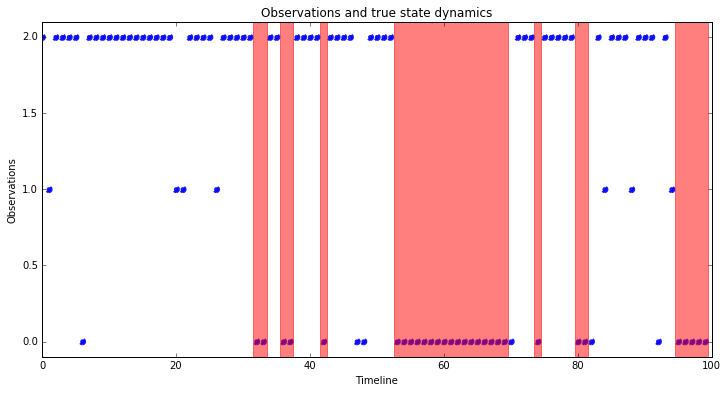

In [713]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.scatter(np.arange(n), y, color='blue', lw=3, alpha=0.9, linestyle='dashed')
for span in spans:
    ax.axvspan(span[0], span[1], alpha=0.5, color='red')
plt.ylim(-0.1, 2.1)
plt.ylabel('Observations')
plt.xlabel('Timeline')
plt.title('Observations and true state dynamics')
plt.xlim(0,n);

**Estimate observations probability via forward and backward algorithms.**

In [714]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A, B.T, a0)
    alpha_prob, beta_prob = hmm.forward_backward_inference(y)

In [715]:
print('Probability of observed data (Forward algorithm): ',alpha_prob)

Probability of observed data (Forward algorithm):  3.57909415651e-31


In [716]:
print('Probability of observed data (Backward algorithm): ', beta_prob)

Probability of observed data (Backward algorithm):  3.57909415651e-31


In [45]:
%lprun -s -f hmm.forward_backward_inference -T lp_results.txt hmm.forward_backward_inference(y)
%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 19.5452 s
File: <ipython-input-36-2890ac55909c>
Function: forward_backward_inference at line 147

Line #      Hits         Time  Per Hit   % Time  Line Contents
   147                                               def forward_backward_inference(self, y):
   148         1            2      2.0      0.0          self.T = len(y)
   149         1            1      1.0      0.0          self._y = y
   150         1            1      1.0      0.0          if hasattr(self, '_graph'):
   151         1           20     20.0      0.0              self._graph.as_default()
   152         1            8      8.0      0.0              tf.reset_default_graph()
   153         1           98     98.0      0.0          self._graph = tf.Graph()
   154         1           12     12.0      0.0          with self._graph.as_default():
   155         1           48     48.0      0.0              with tf.name_scope('Mo

**Use Viterbi algorithm to estimate the most probable state sequence.**

In [574]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A, B.T, a0)
    state_trace = hmm.viterbi_inference(y)

In [575]:
np.mean(X==state_trace.T)

0.93999999999999995

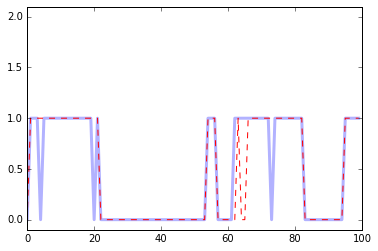

In [576]:
plt.plot(X, color='blue', lw=3, alpha=0.3)
plt.plot(state_trace.T, color='red', linestyle='dashed')
plt.ylim(-0.1, 2.1);

In [49]:
%lprun -s -f hmm.viterbi_inference -T lp_results.txt hmm.viterbi_inference(y)
%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 25.0272 s
File: <ipython-input-36-2890ac55909c>
Function: viterbi_inference at line 168

Line #      Hits         Time  Per Hit   % Time  Line Contents
   168                                               def viterbi_inference(self, y, epsilon=None):
   169         1            5      5.0      0.0          if epsilon is not None:
   170                                                       self.epsilon = epsilon
   171         1            2      2.0      0.0          self.T = len(y)
   172         1            1      1.0      0.0          self._y = y
   173         1            1      1.0      0.0          if hasattr(self, '_graph'):
   174         1           20     20.0      0.0              self._graph.as_default()
   175         1           13     13.0      0.0              tf.reset_default_graph()
   176         1          168    168.0      0.0          self._graph = tf.Graph()
   177    

**Given only the observations, estimate HMM parameters via Baum-Welch algorithm.**

In [627]:
a0_ = np.array([0.99, 0.01])

B_ = np.array([[0.5, 0.1],
              [0.0, 0.5],
              [0.5, 0.5]])

A_ = np.array([[0.1, 0.9],
              [0.9, 0.1]])

In [673]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A_, B_.T, a0_)
    _a0, _A, _B, _gamma, _converged, _delta = hmm.baum_welch_inference(y, max_iter=10000)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

 Converged on step:  32


In [658]:
import gc

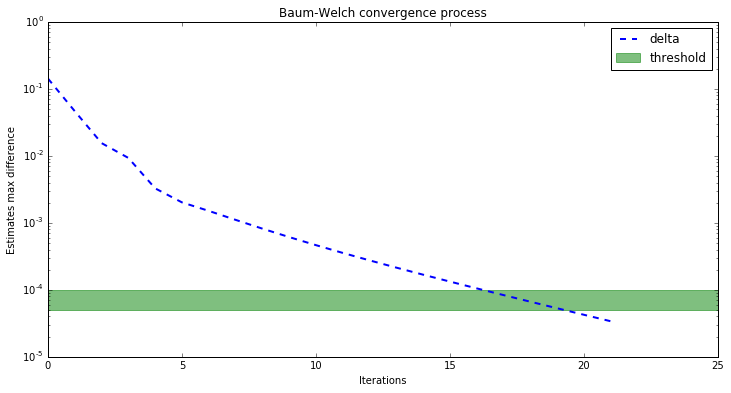

In [672]:
gc.collect() # workaround to prevent crush using log scale - see https://github.com/matplotlib/matplotlib/issues/5208
plt.figure(figsize=(12,6))
plt.plot(_delta[2:], label='delta', color='blue', linestyle='dashed', lw=2)
plt.axhspan(hmm.epsilon/2, hmm.epsilon, alpha=0.5, color='green', label='threshold')
plt.ylabel('Estimates max difference')
plt.xlabel('Iterations')
plt.title('Baum-Welch convergence process')
plt.yscale('log', basey=10)
plt.legend(loc='upper right');

In [668]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(_A[-1], _B[-1], _a0[-1])
    state_trace = hmm.viterbi_inference(y)

In [639]:
np.mean(X==state_trace.T)

0.94999999999999996

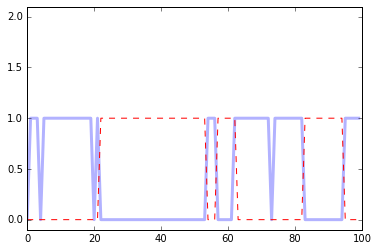

In [584]:
plt.plot(X, color='blue', lw=3, alpha=0.3)
plt.plot(np.logical_not(state_trace.T), color='red', linestyle='dashed')
plt.ylim(-0.1, 2.1);

In [514]:
strip_def = strip_consts(hmm._graph.as_graph_def())
show_graph(strip_def)

In [669]:
centers = np.where(X==0)[0]
lb = centers - 0.5
rb = centers + 0.5
spans = np.vstack((lb,rb)).T
c1 = spans.T[0][1:]
c2 = spans.T[1][:-1]
z1 = np.insert(c1[c1!=c2], 0, spans.T[0][0])
z2 = np.append(c2[c1!=c2], spans.T[1][-1])
spans = np.vstack((z1,z2)).T

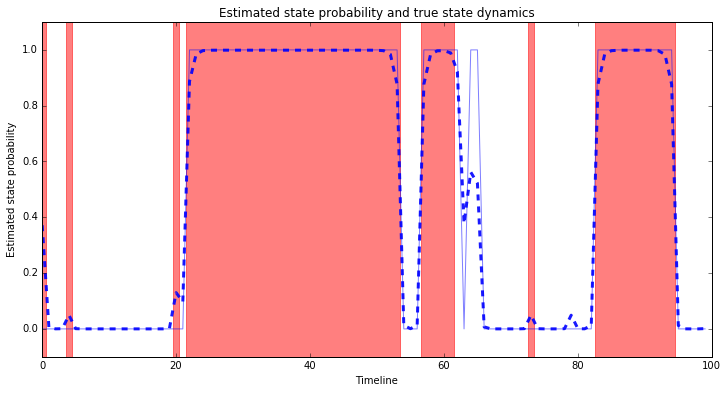

In [670]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.plot(_gamma.T[1], color='blue', lw=3, alpha=0.9, linestyle='dashed')
ax.plot(step_function(_gamma.T[1], 0.5), color='blue', lw=1, alpha=0.5)
for span in spans:
    ax.axvspan(span[0], span[1], alpha=0.5, color='red')
plt.ylim(-0.1, 1.1)
plt.ylabel('Estimated state probability')
plt.xlabel('Timeline')
plt.title('Estimated state probability and true state dynamics')
plt.xlim(0,n);

**Experiments with matrice's deltas**

In [308]:
A = np.array([[ 0.33496942,  0.11162014,  0.55341044], [ 0.28829483,  0.07538859,  0.63631658]])
B = np.array([[ 0.33470766,  0.11165785,  0.5536345 ], [ 0.2888886 ,  0.07533992,  0.63577148]])
E = np.array([[ 0.33449188,  0.11169914,  0.55380898], [ 0.28940652,  0.07530221,  0.63529127]])
C = np.array([[ 0.33415707,  0.1117738 ,  0.55406913], [ 0.29023092,  0.07524238,  0.6345267 ]])
D = np.array([[ 0.33384406,  0.11186972,  0.55428622], [ 0.2910568 ,  0.07518446,  0.63375875]])

A_ = tf.placeholder(dtype=tf.float64, shape=(2,3))
B_ = tf.placeholder(dtype=tf.float64, shape=(2,3))
E_ = tf.placeholder(dtype=tf.float64, shape=(2,3))
C_ = tf.placeholder(dtype=tf.float64, shape=(2,3))
D_ = tf.placeholder(dtype=tf.float64, shape=(2,3))

delta_a0 = tf.reduce_max(tf.abs(A_ - B_))
delta_A = tf.reduce_max(tf.abs(C_ - D_))
delta_B = tf.reduce_max(tf.abs(A_ - E_))

#delta_a0 = tf.reduce_max(tf.abs(tf.reshape(A_, [1,-1]) - tf.reshape(B_, [1,-1]))) 
#delta_A = tf.reduce_max(tf.abs(tf.reshape(C_, [1,-1]) - tf.reshape(D_, [1,-1])))
#delta_B = tf.reduce_max(tf.abs(tf.reshape(A_, [1,-1]) - tf.reshape(E_, [1,-1])))

delta_max = tf.maximum(tf.maximum(delta_a0, delta_A), delta_B)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    delta_val, delta_a0_val, delta_A_val, delta_B_val = sess.run([delta_max, delta_a0, delta_A, delta_B], feed_dict={A_:A, B_:B, C_:C, D_:D, E_:E})
tf.reset_default_graph()
print(delta_val, delta_a0_val, delta_A_val, delta_B_val)

0.00111169 0.00059377 0.00082588 0.00111169


### Continuous Hidden Markov Model

In [686]:
from tensorflow.contrib.distributions import MultivariateNormalDiag
from tensorflow.contrib.distributions import Normal

In [989]:
class TFHiddenMarkovModel(object):
    """ Hidden Markov Model class 
    
    Parameters:    
    -----------
        - S: Number of states
        - O: Emission alphabet capacity
        - A: Transition matrix
        - E: Emission matrix 
        - a0: Initial state probabilities 
    """
    def __init__(self, A, mu, sigma, a0, max_iter=50, epsilon=0.0001, scale=1.):
        # number of states
        self.N = A.shape[0]
        # observations capacity
        self.M = mu.shape[0]
        self._A = A
        self._mu = mu
        self._sigma = sigma
        self._a0 = a0
        self.max_iter = max_iter
        self.initialized = False
        self.converged = False
        self.epsilon = epsilon
        self.scale = scale

    def _initial_state(self, initialized=False):
        if not initialized:
            self.initialized = True
            return Categorical(p=self.a0.initialized_value(), dtype=tf.int32)
        else:
            return Categorical(p=self.a0, dtype=tf.int32)
    
    def _transition(self, state):
        return Categorical(p=self.A[state, :], dtype=tf.int32)

    def _emission(self, state):
        return Normal(self.mu[state], self.sigma[state])

    def _parameter_reinitialization(self):
        self._A = np.random.uniform(size=self.N*self.N).reshape(self.N, self.N)
        self._A = (self._A.T/np.sum(self._A, axis=1)).T
        
        self._mu = np.random.uniform(size=self.M)
        
        self._sigma = np.ones(self.M)*self.scale
        
        self._a0 = np.random.uniform(size=self.N)
        self._a0 = self._a0/np.sum(self._a0)
    
    def _model_definition(self, sampling=True):
        # Transition probability
        self.A = tf.Variable(tf.convert_to_tensor(self._A, dtype=tf.float64), dtype=tf.float64, name='transition_matrix')
        # Emission distribution
        self.mu = tf.Variable(tf.convert_to_tensor(self._mu, dtype=tf.float64), dtype=tf.float64, name='emission_mean')
        self.sigma = tf.Variable(tf.convert_to_tensor(self._sigma, dtype=tf.float64), dtype=tf.float64, name='emission_sigma')
        # Initial state probability
        self.a0 = tf.Variable(tf.convert_to_tensor(self._a0, dtype=tf.float64), dtype=tf.float64, name='init_prob')        
        # observation
        if sampling:
            self.y = tf.Variable([0], dtype=tf.float64, name='observation')
        else:
            self.y = tf.constant(self._y, dtype=tf.float64, name='observation')
    
    def sample(self, n):
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(True)
                # state initialization
            with tf.name_scope('State_Initialization'):
                self.X = tf.Variable(self._initial_state().sample(sample_shape=1), dtype=tf.int32, name='state')
            with tf.name_scope('State_Transition'):
                self.X = tf.assign(self.X, self._transition(self.X[0]).sample(sample_shape=1))
            with tf.name_scope('Emission'):
                self.y = tf.assign(self.y, self._emission(self.X[0]).sample(sample_shape=1))

        states = np.zeros(n)
        observations = np.zeros(n)

        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(n):
                X_, y_ = sess.run([self.X, self.y])
                states[i] = X_
                observations[i] = y_

        return states, observations
    
    def _initialize_frwd_bkwd(self):
        with tf.name_scope('Forward_Backward_Variables_Initialization'):
            self.alpha = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.float64), name='alpha')
            self.scale = tf.Variable(tf.zeros([self.T], dtype=tf.float64), name='scaling_factor')
            self.beta = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.float64), name='beta')
    
    def _forward(self, y):
        initial_state_prob = self._initial_state(initialized=self.initialized).p
        
        n_obs = tf.shape(y)[0]
        n_dim = tf.shape(self.mu)[0]
        self.cond_obs_prob_list = Normal(tf.reshape(tf.tile(self.mu, [n_obs]), [n_obs,n_dim]), tf.reshape(tf.tile(self.sigma, [n_obs]), [n_obs,n_dim])).prob(tf.expand_dims(y,1))
        
        init_obs_prob = tf.multiply(initial_state_prob, self.cond_obs_prob_list[0])
        self.scale = tf.scatter_update(self.scale, 0, 1.0/tf.reduce_sum(init_obs_prob))
        self.alpha = tf.scatter_update(self.alpha, 0, self.scale[0]*init_obs_prob)
        
        for t in range(1, self.T):
            prev_trellis_prob = tf.expand_dims(self.alpha[t - 1, :], 0)
            trans_prior = tf.matmul(prev_trellis_prob, self.A)
            forward_prob = tf.multiply(tf.squeeze(trans_prior), self.cond_obs_prob_list[t])
            
            self.scale = tf.scatter_update(self.scale, t, 1.0/tf.reduce_sum(forward_prob))
            self.alpha = tf.scatter_update(self.alpha, t, self.scale[t]*forward_prob)
            
        alpha = tf.divide(self.alpha, tf.expand_dims(tf.cumprod(self.scale), 1))
        self.alpha_prob = tf.reduce_sum(alpha[self.T-1, :])
        
    def _backward(self, y):
        self.beta = tf.scatter_update(self.beta, self.T - 1, self.scale[self.T - 1]*tf.ones([self.N], dtype=tf.float64))
        
        for t in range(self.T - 2, -1, -1):
            next_trellis_prob = tf.expand_dims(self.beta[t + 1], 1)
            trans_prior = tf.matmul(self.A, tf.diag(tf.squeeze(self.cond_obs_prob_list[t + 1])))
            backward_prob = tf.squeeze(tf.matmul(trans_prior, next_trellis_prob))
            
            self.beta = tf.scatter_update(self.beta, t, self.scale[t]*backward_prob)
        
        beta = tf.divide(self.beta, tf.expand_dims(tf.cumprod(self.scale[::-1])[::-1], 1))
        initial_state_prob = self._initial_state(initialized=self.initialized).p
        init_obs_prob = tf.multiply(initial_state_prob, self.cond_obs_prob_list[0])
        self.beta_prob = tf.reduce_sum(tf.multiply(init_obs_prob, beta[0,:]))
    
    def _delta_propagation(self, delta):
        return tf.add(tf.reshape(delta, (-1,1)), -tf.log(self.A))
    
    def _initialize_viterbi(self):
        self.state_trace = tf.Variable(tf.zeros([self.T], dtype=tf.int64), name='state_trace')
        self.delta = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.float64), name='delta')
        self.psi = tf.Variable(tf.zeros([self.T, self.N], dtype=tf.int64), name='psi')
    
    def _viterbi(self, y):
        log_initial_state_prob = tf.log(self._initial_state(initialized=self.initialized).p)
        log_cond_obs_prob_list = tf.log(self.cond_obs_prob_list)
        self.delta = tf.scatter_update(self.delta, 0, tf.add(-log_initial_state_prob, -log_cond_obs_prob_list[0]))
        for t in range(1, self.T):
            delta = self._delta_propagation(self.delta[t - 1,:])
            self.delta = tf.scatter_update(self.delta, t, tf.reduce_min(delta, 0) - log_cond_obs_prob_list[t])
            self.psi = tf.scatter_update(self.psi, t, tf.argmin(delta, 0))
        
        self.state_trace = tf.scatter_update(self.state_trace, self.T - 1, tf.argmin(self.delta[self.T - 1,:], 0))
        
        for t in range(self.T - 2, -1, -1):
            state = self.state_trace[t + 1]
            idx = tf.reshape(tf.stack([t + 1, state]), [1, -1])
            state_prob = tf.gather_nd(self.psi, idx)
            self.state_trace = tf.scatter_update(self.state_trace, t, state_prob[0])
        
        return self.state_trace
    
    def forward_backward_inference(self, y):
        self.T = len(y)
        self._y = y
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(False)
                self._initialize_frwd_bkwd()
            with tf.name_scope('Forward_Inference'):
                self._forward(self.y)
                self._backward(self.y)
        
        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())
            alpha_prob, beta_prob = sess.run([self.alpha_prob, self.beta_prob])
            
        return alpha_prob, beta_prob
    
    def viterbi_inference(self, y, epsilon=None):
        if epsilon is not None:
            self.epsilon = epsilon
        self.T = len(y)
        self._y = y
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(False)
                self._initialize_frwd_bkwd()
                self._initialize_viterbi()
            with tf.name_scope('Viterbi_Inference'):
                self._forward(self.y)
                state_trace_ = self._viterbi(self.y)
        
        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())
            state_trace = sess.run(state_trace_)
            
        return state_trace
    
    def _posterior(self):
        with tf.name_scope('Posterior_Estimation'):
            self.gamma = tf.multiply(self.alpha, self.beta)
            self.gamma = tf.divide(self.gamma, tf.expand_dims(self.scale, 1))

    def _estimate_emission(self):
        with tf.name_scope('Emission_Estimation'):
            denominator = tf.reduce_sum(self.gamma, 0)
            nominator = tf.matmul(tf.expand_dims(self.y,1), self.gamma, transpose_a=True)
            mu_est = tf.transpose(nominator/denominator)
            
            n_obs = tf.shape(self.y)[0]
            n_dim = tf.shape(self.mu)[0]
            y_m_mu = tf.subtract(tf.expand_dims(self.y, 1), tf.reshape(tf.tile(self.mu, [n_obs]), [n_obs, n_dim]))
            y_m_mu_sq = tf.diag_part(tf.matmul(y_m_mu, tf.transpose(y_m_mu)))
            nominator_sigma = tf.matmul(tf.expand_dims(y_m_mu_sq, 1), self.gamma, transpose_a=True)
            sigma_est = tf.transpose(nominator_sigma/denominator)
            
        return tf.squeeze(mu_est), tf.squeeze(sigma_est)
    
    
    def _estimate_transition(self):        
        for t in range(1, self.T):
            xi = tf.Variable(tf.zeros([self.N, self.N], dtype=tf.float64))
            head_prob = tf.matmul(tf.expand_dims(self.alpha[t-1, :], 0), self.A)
            probs_t = Normal(self.mu, self.sigma).prob(self.y[t])
            path_prob = tf.multiply(head_prob, tf.expand_dims(probs_t, 0))
            denominator = tf.squeeze(tf.matmul(path_prob, tf.expand_dims(self.beta[t, :], 1)))
            for i in range(self.N):
                nominator = self.alpha[t-1, i] * self.A[i, :] * probs_t * self.beta[t, :]
                xi = tf.scatter_update(xi, i, nominator/denominator)
            self.xi = tf.scatter_update(self.xi, t - 1, xi)
        
        A = tf.reduce_sum(self.xi, 0) / tf.expand_dims(tf.reduce_sum(self.gamma, 0), 1) 
        a0 = self.gamma[0,:]
        return a0, A
        
    def _initialize_baum_welch(self):
        self.xi = tf.Variable(tf.zeros([self.T - 1, self.N, self.N], dtype=tf.float64), name='xi')
        self.delta_max = tf.Variable(0., dtype=tf.float64, name='delta_max')
        self.converged = tf.Variable(False, dtype=tf.bool, name='convergence')
        
        
    def check_convergence(self, a0_list, A_list, mu_list, sigma_list):
        if len(a0_list) > 1:
            delta_a0 = np.max(np.abs(a0_list[-1] - a0_list[-2]))
            delta_A = np.max(np.abs(A_list[-1] - A_list[-2]))
            delta_mu = np.max(np.abs(mu_list[-1] - mu_list[-2]))
            delta_sigma = np.max(np.abs(sigma_list[-1] - sigma_list[-2]))
            delta = np.maximum(np.maximum(np.maximum(delta_a0, delta_A), delta_mu), delta_sigma)
            converged = np.logical_and(np.logical_and(np.logical_and(delta_a0<self.epsilon, delta_A<self.epsilon), delta_mu<self.epsilon), delta_sigma<self.epsilon)
        else:
            delta = 1.
            converged = False
        return converged, delta
    
    def _baum_welch(self):
        with tf.name_scope('Forward_Inference'):
            self._forward(self.y) 
        with tf.name_scope('Backward_Inference'):
            self._backward(self.y)
        with tf.name_scope('Believe_Propagation'):
            self._posterior()
        with tf.name_scope('Estimate_Transition'):
            a0, A = self._estimate_transition()
        with tf.name_scope('Estimate_Emission'):
            mu, sigma = self._estimate_emission()
        with tf.name_scope('Update_Parameters'):
            self.a0 = tf.assign(self.a0, a0)
            self.A = tf.assign(self.A, A)
            self.mu = tf.assign(self.mu, mu)
            self.sigma = tf.assign(self.sigma, sigma)
        
        return self.a0, self.A, self.mu, self.sigma, self.gamma
    
    def baum_welch_inference(self, y, max_iter=None):
        if max_iter is None:
            max_iter = self.max_iter
        else:
            self.max_iter = max_iter
        self.T = len(y)
        self._y = y
        self._parameter_reinitialization()
        if hasattr(self, '_graph'):
            self._graph.as_default()
            tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
            with tf.name_scope('Model_Definition'):
                self._model_definition(False)
                self._initialize_frwd_bkwd()
                self._initialize_viterbi()
                self._initialize_baum_welch()
            with tf.name_scope('Baum_Welch_Inference'):
                _a0, _A, _mu, _sigma, _gamma = self._baum_welch()
                
        progress = 0
        printProgress(progress, self.max_iter, prefix = 'Progress:', suffix = 'Complete', barLength = 50)
        deltas = []
        a0_list = []
        A_list = []
        mu_list = []
        sigma_list = []
        deltas = []
        converged_list = []
        converged = False
        exit_condition_fulfilled = False
        exit_condition_count = 0
        with tf.Session(graph=self._graph) as sess:
            sess.run(tf.global_variables_initializer())
            for step in range(self.max_iter):
                if not exit_condition_fulfilled:
                    a0_val, A_val, mu_val, sigma_val, gamma_val = sess.run([_a0, _A, _mu, _sigma, _gamma])
                    a0_list.append(a0_val)
                    A_list.append(A_val)
                    mu_list.append(mu_val)
                    sigma_list.append(sigma_val)
                    converged, delta = self.check_convergence(a0_list, A_list, mu_list, sigma_list)
                    deltas.append(delta)
                    converged_list.append(converged)
                    if converged:
                        exit_condition_count += 1
                        if exit_condition_count == 10:
                            exit_condition_fulfilled = True
                            progress = self.max_iter
                            conv_step = step
                    else:
                        exit_condition_count = 0
                        progress += 1
                    printProgress(progress, self.max_iter, prefix = 'Progress:', suffix = 'Complete', barLength = 50)
        if converged:
            print('\n Converged on step: ', conv_step)
        deltas = np.array(deltas)
        a0_list = np.array(a0_list)
        A_list = np.array(A_list)
        mu_list = np.array(mu_list)
        sigma_list = np.array(sigma_list)
        converged_list = np.array(converged_list)
        return a0_list, A_list, mu_list, sigma_list, gamma_val, converged_list, deltas

In [836]:
a0 = np.array([0.5, 0.5])
mu = np.array([-0.2, 0.2])
sigma = np.array([0.1, 0.1])
A = np.array([[0.85, 0.15],
              [0.12, 0.88]])

In [837]:
# number of observations
n = 100

**Sample from HMM**

In [838]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A, mu, sigma, a0)
    X, y = hmm.sample(n=n)

In [839]:
centers = np.where(X==0)[0]
lb = centers - 0.5
rb = centers + 0.5
spans = np.vstack((lb,rb)).T
c1 = spans.T[0][1:]
c2 = spans.T[1][:-1]
z1 = np.insert(c1[c1!=c2], 0, spans.T[0][0])
z2 = np.append(c2[c1!=c2], spans.T[1][-1])
spans = np.vstack((z1,z2)).T

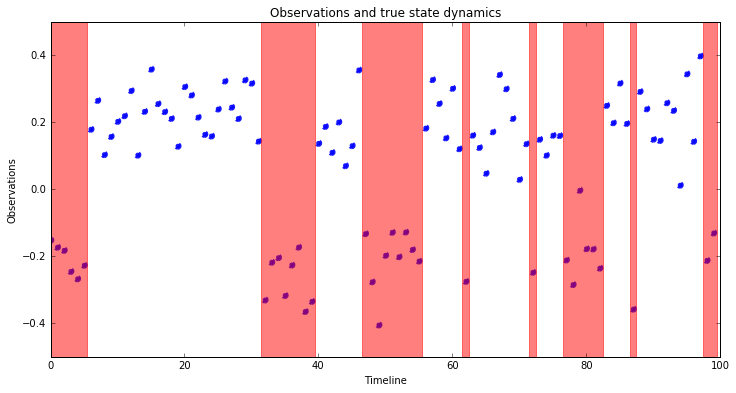

In [840]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.scatter(np.arange(n), y, color='blue', lw=3, alpha=0.9, linestyle='dashed')
for span in spans:
    ax.axvspan(span[0], span[1], alpha=0.5, color='red')
#plt.ylim(-0.1, 2.1)
plt.ylabel('Observations')
plt.xlabel('Timeline')
plt.title('Observations and true state dynamics')
plt.xlim(0,n);

**Probabilities of the observations**

In [747]:
tf.reset_default_graph()
obs = tf.placeholder(dtype=tf.float64, shape=(None))
mu_ = tf.Variable(mu, dtype=tf.float64, name='mu')
sigma_ = tf.Variable(sigma, dtype=tf.float64, name='sigma')

prob = Normal(mu_, sigma_).log_prob(obs)

probs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for y_ in y:
        prob_val = sess.run(prob, feed_dict={obs:y_})
        probs.append(prob_val)
tf.reset_default_graph()
probs = np.array(probs)

In [739]:
np.argmax(probs, axis=1)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [774]:
tf.reset_default_graph()
obs = tf.placeholder(dtype=tf.float64, shape=(None))
mu_ = tf.Variable(mu, dtype=tf.float64, name='mu')
sigma_ = tf.Variable(sigma, dtype=tf.float64, name='sigma')

n_obs = tf.shape(obs)[0]
n_dim = tf.shape(mu_)[0]
prob = Normal(tf.reshape(tf.tile(mu_, [n_obs]), [n_obs,n_dim]), tf.reshape(tf.tile(sigma_, [n_obs]), [n_obs,n_dim])).prob(tf.expand_dims(obs,1))


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    prob_val = sess.run(prob, feed_dict={obs:y})
tf.reset_default_graph()

In [761]:
np.argmax(prob_val, axis=1)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [947]:
tf.reset_default_graph()
obs = tf.placeholder(dtype=tf.float64, shape=(None))
mu_ = tf.Variable(mu, dtype=tf.float64, name='mu')
sigma_ = tf.Variable(sigma, dtype=tf.float64, name='sigma')

n_obs = tf.shape(obs)[0]
n_dim = tf.shape(mu_)[0]
y_m_mu = tf.subtract(tf.expand_dims(obs, 1), tf.reshape(tf.tile(mu_, [n_obs]), [n_obs, n_dim]))
y_m_mu_sq = tf.matmul(y_m_mu, tf.transpose(y_m_mu))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_m_mu_sq_ = sess.run(y_m_mu, feed_dict={obs:y})
tf.reset_default_graph()

In [948]:
y_m_mu_sq_.shape

(100, 2)

In [966]:
tf.reset_default_graph()
obs = tf.placeholder(dtype=tf.float64, shape=(None))
mu_ = tf.Variable(mu, dtype=tf.float64, name='mu')
sigma_ = tf.Variable(sigma, dtype=tf.float64, name='sigma')

n_obs = tf.shape(obs)[0]
n_dim = tf.shape(mu_)[0]
y_m_mu = tf.subtract(tf.expand_dims(obs, 1), tf.reshape(tf.tile(mu_, [n_obs]), [n_obs, n_dim]))
y_m_mu_sq = tf.matmul(tf.transpose(y_m_mu), y_m_mu)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_m_mu_sq_ = sess.run(y_m_mu_sq, feed_dict={obs:y})
tf.reset_default_graph()

In [967]:
y_m_mu_sq_

array([[ 11.73598285,   1.25369052],
       [  1.25369052,   6.77139818]])

**Estimate observations probability via forward and backward algorithms.**

In [841]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A, mu, sigma, a0)
    alpha_prob, beta_prob = hmm.forward_backward_inference(y)

In [842]:
print('Probability of observed data (Forward algorithm): ',alpha_prob)

Probability of observed data (Forward algorithm):  6.20065678748e+26


In [843]:
print('Probability of observed data (Backward algorithm): ', beta_prob)

Probability of observed data (Backward algorithm):  6.20065678748e+26


**Use Viterbi algorithm to estimate the most probable state sequence.**

In [844]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A, mu, sigma, a0)
    state_trace = hmm.viterbi_inference(y)

In [845]:
np.mean(X==state_trace.T)

1.0

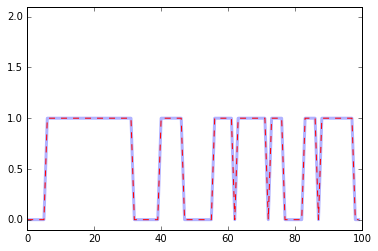

In [846]:
plt.plot(X, color='blue', lw=3, alpha=0.3)
plt.plot(state_trace.T, color='red', linestyle='dashed')
plt.ylim(-0.1, 2.1);

**Given only the observations, estimate HMM parameters via Baum-Welch algorithm.**

In [969]:
a0_ = np.array([0.99, 0.01])

mu_ = np.array([-1., 0.])
sigma_ = np.array([1., 1.])

A_ = np.array([[0.1, 0.9],
              [0.9, 0.1]])

In [990]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(A_, mu_, sigma_, a0_)
    _a0, _A, _mu, _sigma, _gamma, _converged, _delta = hmm.baum_welch_inference(y, max_iter=100)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

 Converged on step:  28


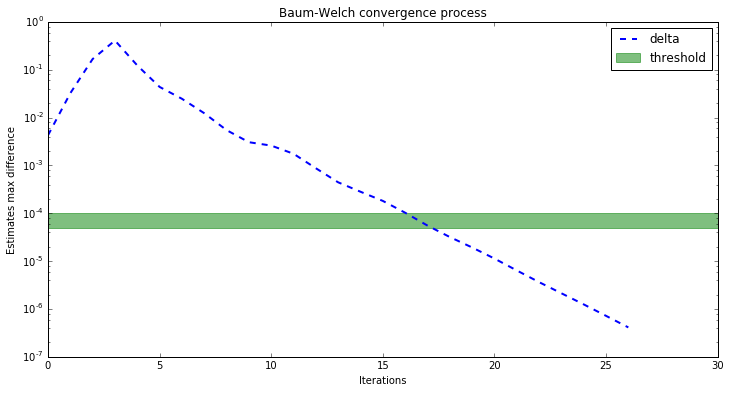

In [991]:
gc.collect() # workaround to prevent crush using log scale - see https://github.com/matplotlib/matplotlib/issues/5208
plt.figure(figsize=(12,6))
plt.plot(_delta[2:], label='delta', color='blue', linestyle='dashed', lw=2)
plt.axhspan(hmm.epsilon/2, hmm.epsilon, alpha=0.5, color='green', label='threshold')
plt.ylabel('Estimates max difference')
plt.xlabel('Iterations')
plt.title('Baum-Welch convergence process')
plt.yscale('log', basey=10)
plt.legend(loc='upper right');

In [994]:
with tf.Graph().as_default():
    hmm = TFHiddenMarkovModel(_A[-1], _mu[-1], _sigma[-1], _a0[-1])
    state_trace = hmm.viterbi_inference(y)

In [995]:
centers = np.where(X==0)[0]
lb = centers - 0.5
rb = centers + 0.5
spans = np.vstack((lb,rb)).T
c1 = spans.T[0][1:]
c2 = spans.T[1][:-1]
z1 = np.insert(c1[c1!=c2], 0, spans.T[0][0])
z2 = np.append(c2[c1!=c2], spans.T[1][-1])
spans = np.vstack((z1,z2)).T

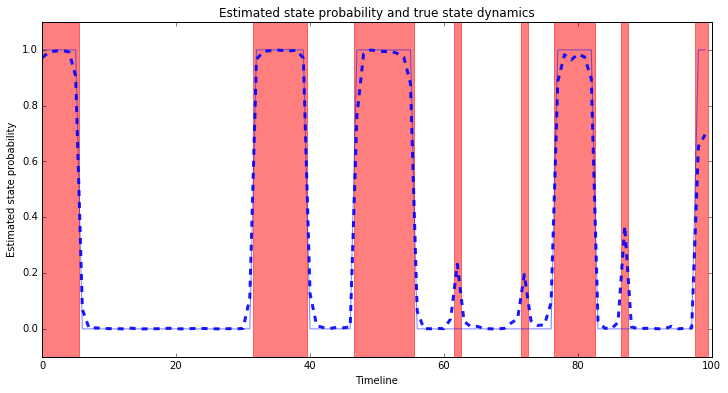

In [996]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.plot(_gamma.T[1], color='blue', lw=3, alpha=0.9, linestyle='dashed')
ax.plot(step_function(_gamma.T[1], 0.5), color='blue', lw=1, alpha=0.5)
for span in spans:
    ax.axvspan(span[0], span[1], alpha=0.5, color='red')
plt.ylim(-0.1, 1.1)
plt.ylabel('Estimated state probability')
plt.xlabel('Timeline')
plt.title('Estimated state probability and true state dynamics')
plt.xlim(0,n);